In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

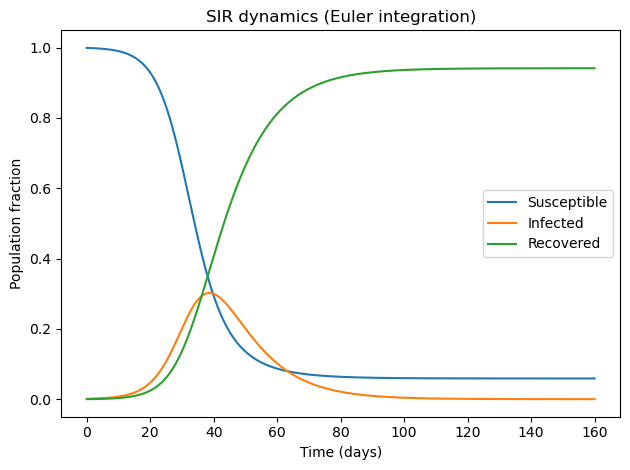

In [3]:
# Simple Euler integration of the classic SIR model
beta = 0.3    # transmission rate
gamma = 0.1   # recovery rate
N = 1.0       # population (normalised to 1)

# Initial conditions: 0.1 % infected, rest susceptible
S0, I0, R0 = 0.999, 0.001, 0.0

t_max, dt = 160, 0.1
n_steps = int(t_max / dt)

S = np.empty(n_steps)
I = np.empty(n_steps)
R = np.empty(n_steps)
t = np.linspace(0, t_max, n_steps)

S[0], I[0], R[0] = S0, I0, R0

for k in range(1, n_steps):
    dS = -beta * S[k-1] * I[k-1]
    dI = beta * S[k-1] * I[k-1] - gamma * I[k-1]
    dR = gamma * I[k-1]

    S[k] = S[k-1] + dS * dt
    I[k] = I[k-1] + dI * dt
    R[k] = R[k-1] + dR * dt

plt.figure()
plt.plot(t, S, label="Susceptible")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("SIR dynamics (Euler integration)")
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
# skeleton_sird_logincidence.py
# ------------------------------------------------------------
# 0. Imports & RNG ------------------------------------------------------------
#from kernprof import profile 
import numpy as np
from scipy.stats import binom
rng = np.random.default_rng(seed=42)
from numba import njit

# 1. One-step state transition -----------------------------------------------
def one_step(S, I, R, D, beta, k, gamma, mu, rng):
    """Discrete-time SIRD with log-incidence; all counts are integers"""
    p_inf = 1 - (k / (k + beta*I))**k
    new_inf = rng.binomial(S, p_inf)

    p_rec = 1 - np.exp(-gamma)
    recov = rng.binomial(I, p_rec)

    p_die = 1 - np.exp(-mu)
    deaths = rng.binomial(I - recov, p_die)

    return (S - new_inf,
            I + new_inf - recov - deaths,
            R + recov,
            D + deaths,
            new_inf, recov, deaths)   # return events for likelihood

# 2. Simulation helper --------------------------------------------------------
#
def simulate_trajectory(params, S0, I0, R0, D0, T, rng):
    S, I, R, D = S0, I0, R0, D0
    events = []        # store (inf, rec, die) for likelihood
    states = [(S,I,R,D)]
    for _ in range(T):
        S, I, R, D, *ev = one_step(S, I, R, D, *params, rng)
        states.append((S,I,R,D))
        events.append(ev)
    return np.array(states), np.array(events)

# 3. Log-likelihood -----------------------------------------------------------
#@njit(cache=True, fastmath=True)
def loglike(params, events, susceptibles, infectious):
    beta, k, gamma, mu = params
    logp = 0.0
    for (new_inf, recov, deaths), S, I in zip(events, susceptibles, infectious):
        # infection piece
        p_inf = 1 - (k/(k+beta*I))**k
        logp += binom.logpmf(new_inf, S, p_inf)

        # recovery piece
        p_rec = 1 - np.exp(-gamma)
        logp += binom.logpmf(recov, I, p_rec)

        # death piece
        p_die = 1 - np.exp(-mu)
        logp += binom.logpmf(deaths, I - recov, p_die)
    return logp

def mcmc(data_states, data_events,
         n_iter= 10000, rng=rng):
    # start values
    beta, k, gamma, mu = 0.002, 10.0, 0.2, 0.01
    chain = []

    # pre-split data for speed
    S_hist = data_states[:-1,0]   # susceptibles at each t
    I_hist = data_states[:-1,1]   # infectious at each t
    
    for it in range(n_iter):
        # -------- Gibbs for gamma -----------
        succ_rec = data_events[:,1].sum()
        fail_rec = I_hist.sum() - succ_rec
        p_rec = rng.beta(1+succ_rec, 1+fail_rec)
        gamma = -np.log1p(-p_rec)

        # -------- Gibbs for mu --------------
        succ_die = data_events[:,2].sum()
        fail_die = (I_hist - data_events[:,1]).sum() - succ_die
        p_die = rng.beta(1+succ_die, 1+fail_die)
        mu = -np.log1p(-p_die)

        # -------- Metropolis for beta -------
        beta_prop = rng.lognormal(mean=np.log(beta), sigma=0.15)
        acc = (loglike((beta_prop,k,gamma,mu), events, S_hist, I_hist) -
               loglike((beta,     k,gamma,mu), events, S_hist, I_hist))
        if np.log(rng.random()) < acc:
            beta = beta_prop

        # -------- Metropolis for k ----------
        k_prop = rng.uniform(0.99*k,1.01*k) #same as paper 
        acc = (loglike((beta,k_prop,gamma,mu), data_events, S_hist, I_hist) -
               loglike((beta,k,gamma,mu), data_events, S_hist, I_hist))
        if np.log(rng.random()) < acc:
            k = k_prop

        chain.append([beta, k, gamma, mu])

    return np.array(chain)

# 5. Driver stub --------------------------------------------------------------

# synthetic data for quick test
true_params = (0.003, 10, 0.25, 0.02)
states, events = simulate_trajectory(true_params,
                                        S0=990, I0=10, R0=0, D0=0,
                                        T=40, rng=rng)
samples = mcmc(states, events)

#print("Posterior means:", samples.mean(0))
#print("95% CI:", np.percentile(samples, [2.5,97.5], axis=0))


Posterior means: [3.19698680e-03 6.30588764e+00 2.56041275e-01 1.77855276e-02]
95% CI: [[2.97482653e-03 4.92791088e+00 2.39784605e-01 1.34778784e-02]
 [3.42621478e-03 9.35464080e+00 2.72540468e-01 2.27306859e-02]]


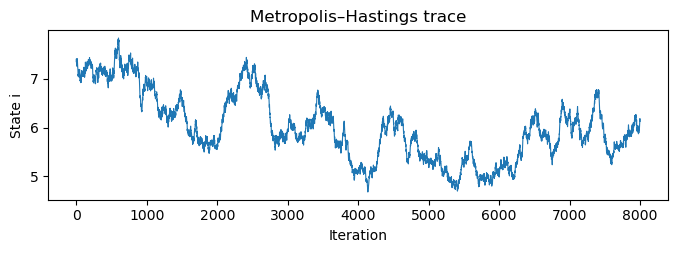

0.9954994374296787

In [44]:
print("Posterior means:", samples.mean(0))
print("95% CI:", np.percentile(samples, [2.5,97.5], axis=0))
plt.figure(figsize=(8,2.2))
plt.plot(samples[2000:,1], lw=0.8)      # first 2 000 iterations
plt.xlabel("Iteration")
plt.ylabel("State i")
plt.title("Metropolis–Hastings trace")
plt.show()
len(samples[200:])
jumps = np.diff(samples[2000:, 1]) != 0.0
jumps.mean()

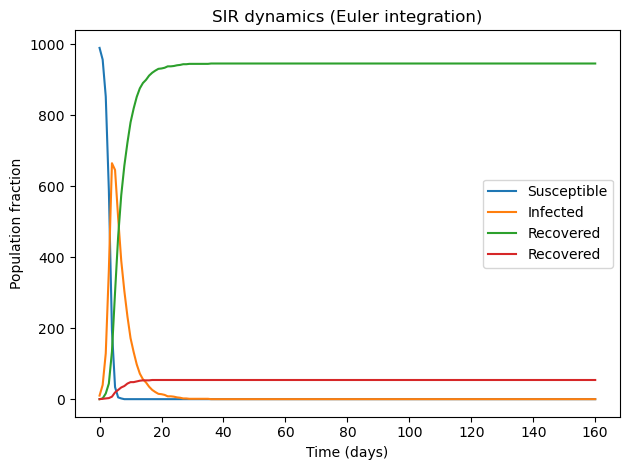

In [ ]:
S = states[:,0]
I = states[:,1]
R = states[:,2]
D = states[:,3]

T = range(161)
plt.figure()
plt.plot(T, S, label="Susceptible")
plt.plot(T, I, label="Infected")
plt.plot(T, R, label="Recovered")
plt.plot(T, D, label="Deaths")

plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("SIR dynamics (Euler integration)")
plt.legend()
plt.tight_layout()
plt.show()

161

In [9]:
from numba import jit

@jit
def one_step(S, I, R, D, beta, k, gamma, mu, rng):
    p_i = 1 - (k / (k + beta*I))**k
    new_inf = rng.binomial(S, p_i)

    p_r = 1 - np.exp(-gamma)
    recov = rng.binomial(I, p_r)

    p_d = 1 - np.exp(-mu)
    deaths = rng.binomial(I - recov, p_d)

    S -= new_inf
    I += new_inf - recov - deaths
    R += recov
    D += deaths
    return S, I, R, D